# P1 - TSA - Acceso a Internet en Colombia

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [510]:
# Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import plotly as pt
import plotly.express as px
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot
from pandas import DatetimeIndex
from pandas import Series
from tabulate import tabulate
from pandas import DataFrame

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

%matplotlib inline
sns.set()  

In [511]:
# Leer el archivo 'datos.csv'
df = pd.read_excel("DataSet/P1_Serie_Acceso_Internet_Trim.xlsx",index_col=0)

# Parte A. Contexto y relevancia del problema

### $\color{red}{\text{TODOS}}$ 

Para el desarrollo del proyecto, se utilizó la serie de tiempo del porcentaje de penetración de Internet dedicado en Colombia (% de la población).

Número de suscriptores con acceso a Internet, fijo y móvil, según los datos reportados por los proveedores al último día de cada trimestre como porcentaje de la población basados en las proyecciones de población del DANE.

Fuente: Ministerio de las TIC https://colombiatic.mintic.gov.co/

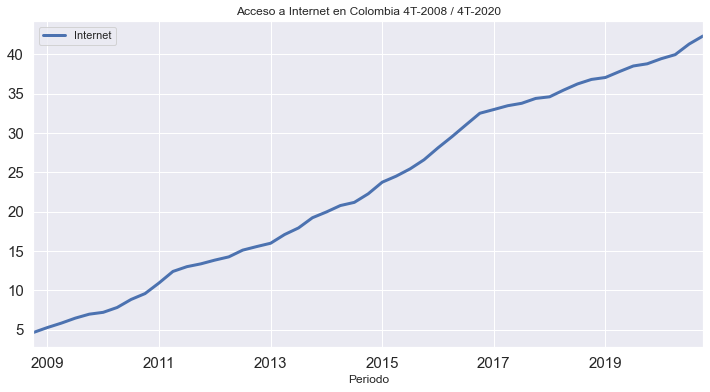

In [512]:
df.plot(figsize=(12, 6),linewidth=3, fontsize=15, title='Acceso a Internet en Colombia 4T-2008 / 4T-2020');

In [513]:
df.Internet.describe()

count    49.000000
mean     23.267556
std      11.852783
min       4.633165
25%      13.362776
50%      22.276354
75%      34.406101
max      42.350991
Name: Internet, dtype: float64

In [514]:
df.head()

,Internet
Periodo,
2008-12-31,4.633165
2009-03-31,5.260111
2009-06-30,5.823407
2009-09-30,6.457031
2009-12-31,6.960836


### Suscripciones a banda ancha fija (por cada 100 personas) en Latam

In [515]:
table_Latam = [['Colombia','13.8%'],['Argentina','19.6%'],['Brasil','15.6%'],['Ecuador','12.0%'],['Latam','14.1%'],['México','15.2%']]
headers = ['País', 'año 2018']
print(tabulate(table_Latam,headers))

País       año 2018
---------  ----------
Colombia   13.8%
Argentina  19.6%
Brasil     15.6%
Ecuador    12.0%
Latam      14.1%
México     15.2%


### Suscripciones a banda ancha fija (por cada 100 personas) en Países Desarrollados

In [516]:
table_GP = [['Alemania','42.0%'],['China','31.3%'],['Estados Unidos','34.7%'],['Japón','33.5%'],['OECD','31.8%'],['Reino Unido','39.7%']]
headers = ['País', 'año 2018']
print(tabulate(table_GP,headers))

País            año 2018
--------------  ----------
Alemania        42.0%
China           31.3%
Estados Unidos  34.7%
Japón           33.5%
OECD            31.8%
Reino Unido     39.7%


# Parte B. Análisis de los principales componentes de la serie

### $\color{red}{\text{JAIME}}$ 

# Estacionariedad

In [517]:
#DF Test
result = adfuller(df['Internet'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.040810
p-value: 0.955024
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


En este caso, el test no rechaza la Ho de que la serie no es estacionaria.

# Tendencia

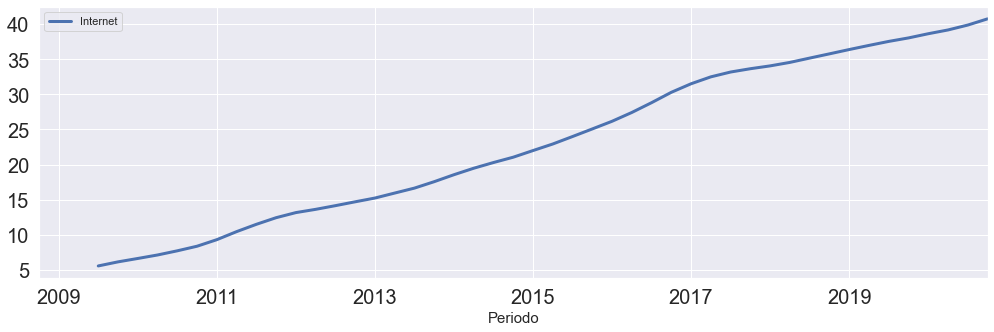

In [518]:
df.rolling(4).mean().plot(figsize=(17,5), linewidth=3, fontsize=20)
plt.xlabel('Periodo', fontsize=15);

# Serie sin Tendencia

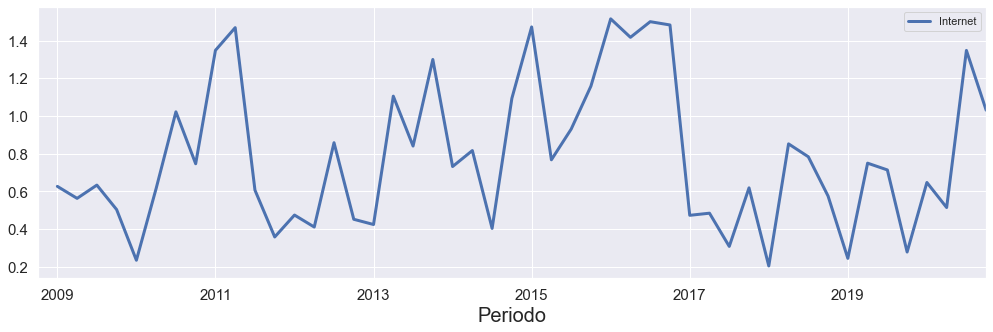

In [519]:
df.diff().plot(figsize=(17,5), linewidth=3, fontsize=15)
plt.xlabel('Periodo', fontsize=20);

In [520]:
result = adfuller(df['Internet'].diff().iloc [ 1 :]) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.179342
p-value: 0.000714
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


Al eliminar la tendencia, la serie es estacionaria.

# Autocorrelación

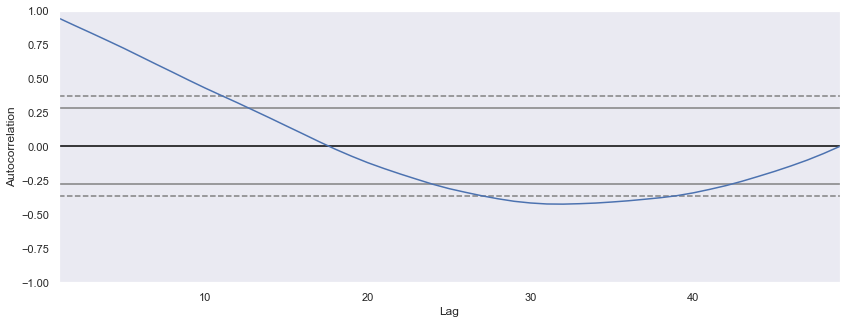

In [521]:
plt.figure(figsize=(14,5))
pd.plotting.autocorrelation_plot(df);

# Parte C. Modelos y Proyecciones

In [522]:
warnings.filterwarnings('ignore')

## C.1. Modelos ARIMA

### $\color{red}{\text{JUANITA-ALEX}}$ 

## 1. Modelos

Se transforma la serie en logaritmo y se diferencia una vez:

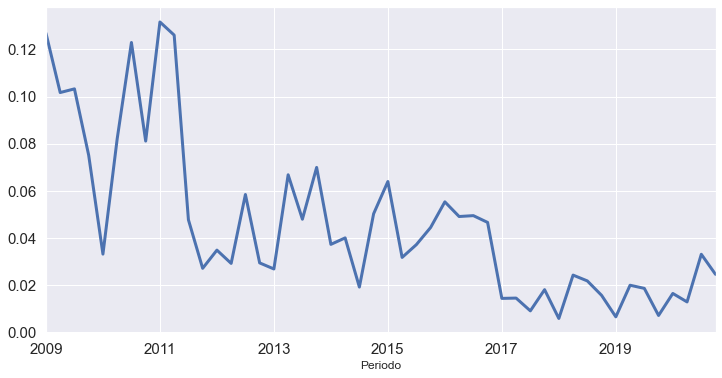

In [523]:
df['log_Internet'] = np.log(df['Internet'])
df_log=df.iloc[:,1:3]
df_log= df.log_Internet.diff()
df_log=df_log.dropna()
df_log.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [524]:
result = adfuller(df_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.297381
p-value: 0.014996
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


La serie diferenciada es estacionaria, dado que se rechaza la Ho de que la serie es no estacionaria.

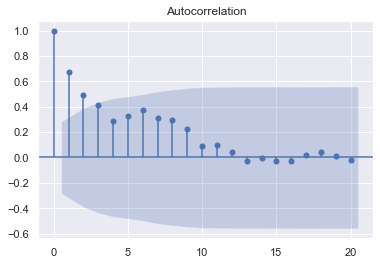

In [525]:
# Función de Autocorrelación
serie = np.log(df['Internet']).diff().dropna()
plot_acf(serie,lags=20);

La ACF sugiere un proceso MA de orden 3.

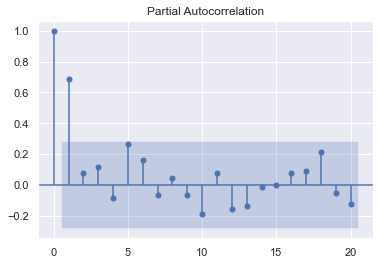

In [526]:
#Función de Autocorrelación Parcial
plot_pacf(serie,lags=20);

La PACF sugiere un autorregresivo de orden 2.

A continuación se definen las bases de entrenamiento (80%) y de pruebas (20%):

In [527]:
#Bases de train y test
X = df['Internet'].values
size = int(len(X) * 0.80) # 80% train, 20% test
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]

Se procede a estimar ahora los siguientes modelos:

### a. Modelo ARIMA(2,1,3)

In [528]:
# fit modelo 1 - ARIMA(2,1,3)
model1 = ARIMA(np.log(history), order=(2,1,3))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 3)   Log Likelihood                  83.129
Method:                       css-mle   S.D. of innovations              0.027
Date:                Thu, 15 Jul 2021   AIC                           -152.258
Time:                        00:38:39   BIC                           -140.795
Sample:                             1   HQIC                          -148.180
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0545      0.007      7.540      0.000       0.040       0.069
ar.L1.D.y      0.0528      0.118      0.449      0.653      -0.178       0.283
ar.L2.D.y      0.9472      0.120      7.869      0.0

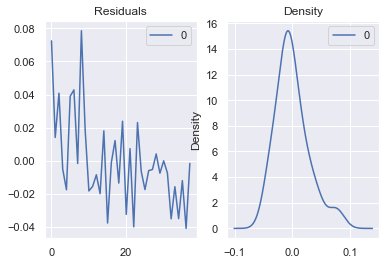

In [529]:
# plot residual errors
residuals = pd.DataFrame(model1_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  37.451142  36.247135
1  39.522632  36.822584
2  41.781185  37.067690
3  44.096223  37.817613
4  46.612087  38.531663
5  49.198848  38.810409
6  52.001781  39.457992
7  54.891700  39.972537
8  58.014906  41.320338
9  61.243051  42.350991


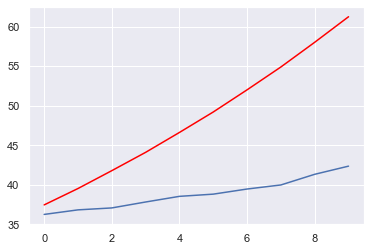

Test MSE: 125.914


In [530]:
# Real vs Proyectado
output = model1_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse1 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse1)

### b. Modelo ARIMA(2,1,1)

In [531]:
# fit modelo 2 - ARIMA(2,1,1)
model2 = ARIMA(np.log(history), order=(2,1,1))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  85.204
Method:                       css-mle   S.D. of innovations              0.025
Date:                Thu, 15 Jul 2021   AIC                           -160.409
Time:                        00:38:40   BIC                           -152.221
Sample:                             1   HQIC                          -157.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0558      0.010      5.442      0.000       0.036       0.076
ar.L1.D.y      1.6811      0.125     13.480      0.000       1.437       1.925
ar.L2.D.y     -0.6897      0.122     -5.644      0.0

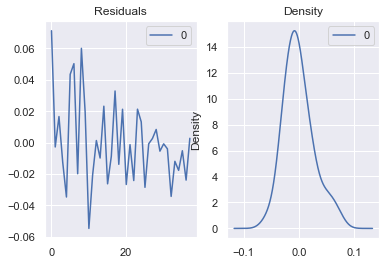

In [532]:
# plot residual errors
residuals = pd.DataFrame(model2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  36.709762  36.247135
1  38.275843  36.822584
2  40.113104  37.067690
3  42.190137  37.817613
4  44.487033  38.531663
5  46.991943  38.810409
6  49.698846  39.457992
7  52.606069  39.972537
8  55.715259  41.320338
9  59.030679  42.350991


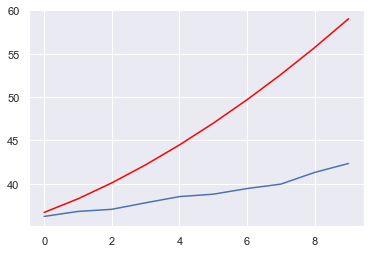

Test MSE: 88.303


In [533]:
#Real vs Proyectado
output = model2_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse2 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse2)

### c. Modelo ARIMA(2,1,0)

In [534]:
# fit modelo 3 - ARIMA(2,1,0)
model3 = ARIMA(np.log(history), order=(2,1,0))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  85.104
Method:                       css-mle   S.D. of innovations              0.026
Date:                Thu, 15 Jul 2021   AIC                           -162.208
Time:                        00:38:40   BIC                           -155.658
Sample:                             1   HQIC                          -159.877
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0560      0.013      4.198      0.000       0.030       0.082
ar.L1.D.y      0.6708      0.164      4.087      0.000       0.349       0.992
ar.L2.D.y      0.0358      0.172      0.208      0.8

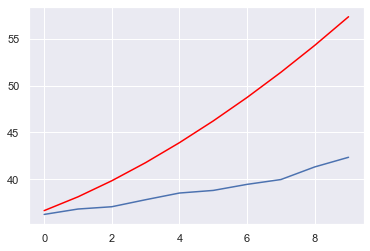

Test MSE: 72.084


In [535]:
#Real vs Proyectado
output = model3_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
#print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse3 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse3)

### d. Modelo ARIMA(1,1,1)

In [536]:
# fit modelo 4 - ARIMA(1,1,1)
model4 = ARIMA(np.log(history), order=(1,1,1))
model4_fit = model4.fit(disp=0)
print(model4_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  85.119
Method:                       css-mle   S.D. of innovations              0.026
Date:                Thu, 15 Jul 2021   AIC                           -162.237
Time:                        00:38:41   BIC                           -155.687
Sample:                             1   HQIC                          -159.907
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0561      0.014      4.078      0.000       0.029       0.083
ar.L1.D.y      0.7405      0.202      3.670      0.000       0.345       1.136
ma.L1.D.y     -0.0839      0.303     -0.277      0.7

     predict       real
0  36.627009  36.247135
1  38.063737  36.822584
2  39.738487  37.067690
3  41.627921  37.817613
4  43.716885  38.531663
5  45.996163  38.810409
6  48.460985  39.457992
7  51.109998  39.972537
8  53.944542  41.320338
9  56.968140  42.350991


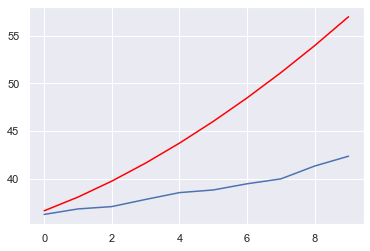

Test MSE: 67.999


In [537]:
#Real vs Proyectado
output = model4_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse4 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse4)

### e. Modelo ARIMA(1,2,1)

In [538]:
# fit modelo 5 - ARIMA(1,2,1)
model5 = ARIMA(np.log(history), order=(1,2,1))
model5_fit = model5.fit(disp=0)
print(model5_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  85.663
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 15 Jul 2021   AIC                           -163.327
Time:                        00:38:41   BIC                           -156.883
Sample:                             2   HQIC                          -161.055
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -4.013      0.000      -0.003      -0.001
ar.L1.D2.y     0.4191      0.159      2.640      0.008       0.108       0.730
ma.L1.D2.y    -1.0000      0.081    -12.341      0.0

     predict       real
0  36.006172  36.247135
1  36.370598  36.822584
2  36.612484  37.067690
3  36.755223  37.817613
4  36.808508  38.531663
5  36.776499  38.810409
6  36.661317  39.457992
7  36.464535  39.972537
8  36.187801  41.320338
9  35.833091  42.350991


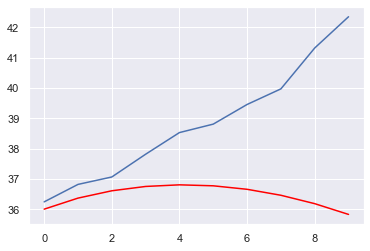

Test MSE: 9.766


In [539]:
#Real vs Proyectado
output = model5_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse5 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse5)

### f. Modelo ARIMA(1,2,0)

In [540]:
# fit modelo 6 - ARIMA(1,2,0)
model6 = ARIMA(np.log(history), order=(1,2,0))
model6_fit = model6.fit(disp=0)
print(model6_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(1, 2, 0)   Log Likelihood                  81.478
Method:                       css-mle   S.D. of innovations              0.027
Date:                Thu, 15 Jul 2021   AIC                           -156.956
Time:                        00:38:41   BIC                           -152.123
Sample:                             2   HQIC                          -155.252
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.004     -0.755      0.450      -0.010       0.004
ar.L1.D2.y    -0.2054      0.161     -1.274      0.203      -0.521       0.111
                                    Roots           

     predict       real
0  36.078998  36.247135
1  36.636683  36.822584
2  37.093394  37.067690
3  37.453443  37.817613
4  37.712207  38.531663
5  37.867901  38.810409
6  37.919164  39.457992
7  37.865587  39.972537
8  37.707611  41.320338
9  37.446543  42.350991


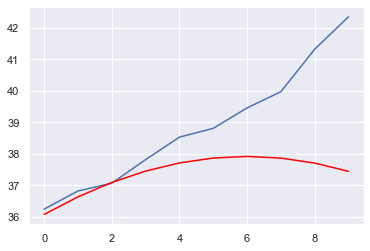

Test MSE: 4.567


In [541]:
#Real vs Proyectado
output = model6_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse6 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse6)

### Comparación de modelos ARIMA

In [542]:
# Comparación de MSE
table_MSE = [['ARIMA (2,1,3)', round(mse1,3)],['ARIMA (2,1,1)', round(mse2,3)],['ARIMA (2,1,0)', round(mse3,3)],
            ['ARIMA (1,1,1)', round(mse4,3)],['ARIMA (1,2,1)', round(mse5,3)],['ARIMA (1,2,0)', round(mse6,3)]]
headers = ['Modelo', 'MSE ']
print(tabulate(table_MSE,headers,stralign="decimal"))

       Modelo     MSE
-------------  -------
ARIMA (2,1,3)  125.914
ARIMA (2,1,1)   88.303
ARIMA (2,1,0)   72.084
ARIMA (1,1,1)   67.999
ARIMA (1,2,1)    9.766
ARIMA (1,2,0)    4.567


Se selecciona el modelo ARIMA(1,2,0) por tener menor MSE.

## 2. Proyección a 2 años (fuera de la muestra)

In [557]:
#Modelo final con todos los datos
model_def = ARIMA(np.log(X), order=(1,2,0))
model_def_fit = model_def.fit(disp=0)
print(model_def_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   47
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 108.260
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 15 Jul 2021   AIC                           -210.521
Time:                        00:39:25   BIC                           -204.970
Sample:                             2   HQIC                          -208.432
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.706      0.480      -0.008       0.004
ar.L1.D2.y    -0.2088      0.142     -1.466      0.143      -0.488       0.070
                                    Roots           

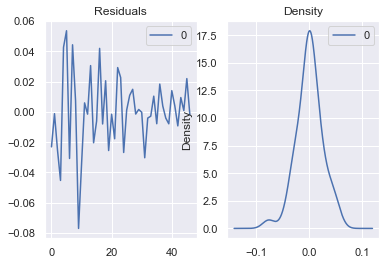

In [558]:
# plot residual errors
residuals = pd.DataFrame(model_def_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

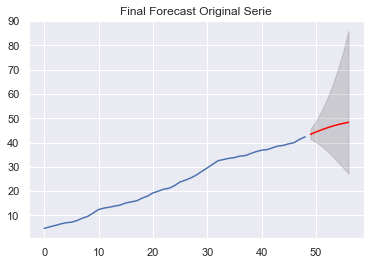

In [559]:
#Proyección por fuera de la muestra
n_periods = 8
fc, se, conf = model_def_fit.forecast(steps=n_periods)

#Extraer series
index_of_fc = np.arange(len(X), len(X)+n_periods)
fc_serie = np.exp(pd.Series(fc, index=index_of_fc))
lower_serie = np.exp(pd.Series(conf[:, 0], index=index_of_fc))
upper_serie = np.exp(pd.Series(conf[:, 1], index=index_of_fc))

# Gráfico
plt.plot(X)
plt.plot(fc_serie, color='red')
plt.fill_between(lower_serie.index,lower_serie, upper_serie, 
                 color='k', alpha=.15)
plt.title("Final Forecast Original Serie")
plt.show()

In [560]:
trimestres=['1T-21','2T-21','3T-21','4T-21','1T-22','2T-22','3T-22','4T-22']
trimestres=pd.DataFrame(trimestres)
table_proy = [[trimestres[-0],round(fc_serie[:],1), round(lower_serie,1), round(upper_serie,1)]]
headers = ['Periodo','Proyección', 'Límite inferior','Límite superior']
print(tabulate(table_proy,headers))

Periodo                 Proyección      Límite inferior    Límite superior
----------------------  --------------  -----------------  -----------------
0    1T-21              49    43.4      49    41.4         49    45.5
1    2T-21              50    44.3      50    40.2         50    48.8
2    3T-21              51    45.2      51    38.6         51    52.9
3    4T-21              52    46.0      52    36.6         52    57.7
4    1T-22              53    46.7      53    34.4         53    63.3
5    2T-22              54    47.3      54    32.1         54    69.8
6    3T-22              55    47.9      55    29.6         55    77.4
7    4T-22              56    48.3      56    27.1         56    86.0
Name: 0, dtype: object  dtype: float64  dtype: float64     dtype: float64


## C.2. Modelo Prophet

## 1. Modelo ###

In [547]:
df2 = pd.read_csv("DataSet/P1_Serie_Acceso_Internet_Trim.csv",sep=';',decimal=',')
df2.columns = ['ds', 'y']
df2['ds'] = pd.DatetimeIndex(df2['ds'])
df2.head()

,ds,y
0,2008-12-31,4.63
1,2009-03-31,5.26
2,2009-06-30,5.82
3,2009-09-30,6.46
4,2009-12-31,6.96


In [548]:
m = Prophet(yearly_seasonality=4)
m.fit(df2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 2. Proyección a 2 años (fuera de la muestra) ###

In [549]:
future = m.make_future_dataframe(periods=8, freq='Q')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8)

,ds,yhat,yhat_lower,yhat_upper
49,2021-03-31,42.031628,41.563419,42.479831
50,2021-06-30,42.651492,42.183032,43.134282
51,2021-09-30,43.372511,42.895071,43.858524
52,2021-12-31,44.040586,43.510703,44.557433
53,2022-03-31,44.376928,43.837927,44.910407
54,2022-06-30,45.061044,44.429114,45.616327
55,2022-09-30,45.649007,44.987496,46.305003
56,2022-12-31,46.191290,45.488292,46.923679


### Plotting the Forecast

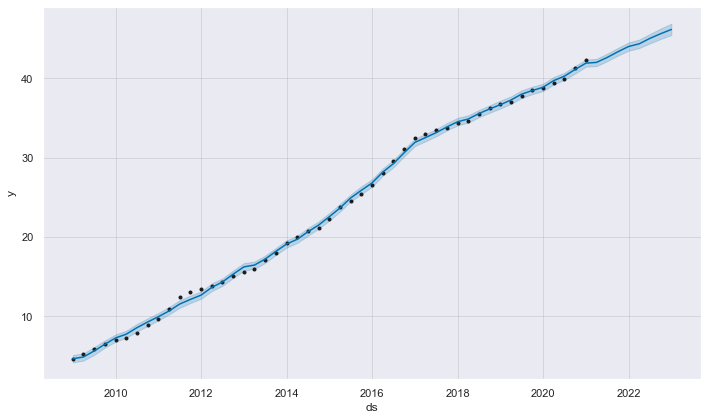

In [550]:
m.plot(forecast);

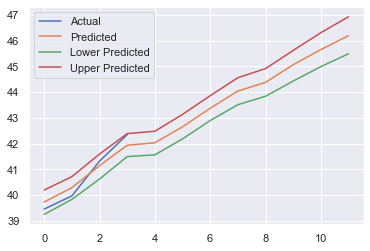

In [551]:
y_true = df2['y'][-4:].values
y_pred = forecast['yhat'][-12:].values
y_pred_lower = forecast['yhat_lower'][-12:].values
y_pred_upper = forecast['yhat_upper'][-12:].values

pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.plot(y_pred_lower, label='Lower Predicted')
pyplot.plot(y_pred_upper, label='Upper Predicted')
pyplot.legend()
pyplot.show()

### Decomposing the Forecast

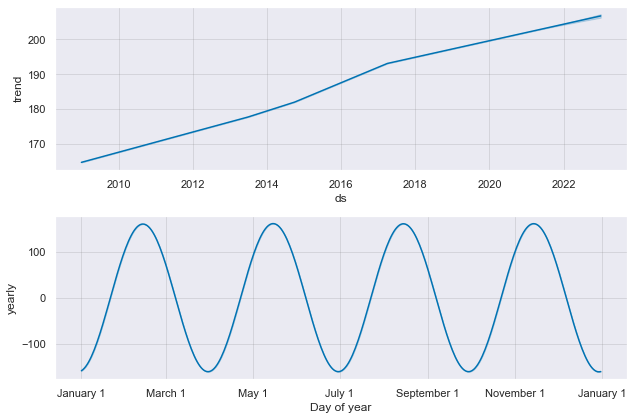

In [552]:
m.plot_components(forecast);

### Cross-validation

In [553]:
cutoffs = pd.date_range(start='2014-06-30', end='2018-06-30', freq='3MS')
print(cutoffs)

df_cv = cross_validation(model=m, horizon='730 days', cutoffs=cutoffs)

DatetimeIndex(['2014-07-01', '2014-10-01', '2015-01-01', '2015-04-01',
               '2015-07-01', '2015-10-01', '2016-01-01', '2016-04-01',
               '2016-07-01', '2016-10-01', '2017-01-01', '2017-04-01',
               '2017-07-01', '2017-10-01', '2018-01-01', '2018-04-01'],
              dtype='datetime64[ns]', freq='3MS')


INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


In [554]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,91 days,1.283474,1.132905,1.004758,0.033114,0.037175,0.033278,0.233333
1,180 days,1.233016,1.110413,0.972781,0.031396,0.031963,0.031290,0.183333
2,181 days,1.905554,1.380418,1.152997,0.037420,0.031963,0.037538,0.187500
3,182 days,2.865433,1.692759,1.494192,0.047876,0.049898,0.048211,0.083333
4,183 days,2.793588,1.671403,1.467848,0.047244,0.053436,0.047681,0.145833
5,272 days,2.455735,1.567079,1.347471,0.041685,0.042174,0.041357,0.166667
6,273 days,3.967413,1.991836,1.696293,0.053301,0.047325,0.053650,0.104167
7,274 days,4.954548,2.225881,2.023182,0.064074,0.064872,0.064906,0.027778
8,364 days,4.938451,2.222263,1.924966,0.056580,0.059017,0.055099,0.166667
9,365 days,7.018715,2.649286,2.381160,0.073721,0.078076,0.074827,0.111111


In [555]:
performance_metrics(df_cv).describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,25,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,437 days 09:36:00,8.400656,2.748480,2.506828,0.075177,0.081234,0.075412,0.080849
std,190 days 02:46:03.292300394,4.959898,0.939033,0.915393,0.025147,0.028755,0.025214,0.068968
min,91 days 00:00:00,1.233016,1.110413,0.972781,0.031396,0.031963,0.031290,0.000000
25%,273 days 00:00:00,3.967413,1.991836,1.696293,0.053301,0.053436,0.053650,0.013889
50%,456 days 00:00:00,8.360634,2.891476,2.660341,0.081079,0.092037,0.081622,0.083333
75%,549 days 00:00:00,12.400033,3.521368,3.278574,0.094516,0.104817,0.095408,0.111111
max,730 days 00:00:00,18.373231,4.286401,3.883147,0.111047,0.115039,0.112211,0.233333


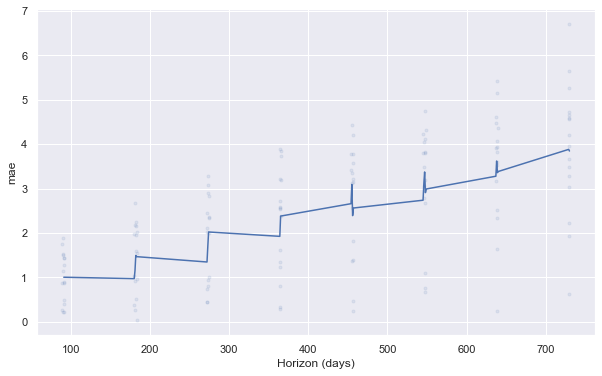

In [556]:
plot_cross_validation_metric(df_cv, metric='mae');

# Conclusiones

### $\color{red}{\text{TODOS}}$ 